In [1]:
from FVG import FVGStrategy
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('/Users/hatim/Desktop/Applied Forecasting/Final Project/Algo Trading/data.csv')

rf = df['Risk Free Rate']
btc = df.drop(columns=['Risk Free Rate'])

strategy = FVGStrategy(lookback_period=10, body_multiplier=1.2, backcandles=50, test_candles=15, upside_scaler=2, downside_scaler=1.2)
signals_df = strategy.generate_signals(btc)

Calculating Position Percentages: 100%|██████████| 3562/3562 [00:00<00:00, 235815.81it/s]

Signal Generation Complete


                    PERFORMANCE SUMMARY                     

                          RETURNS                           
------------------------------------------------------------
Strategy Total Return:       39566.18%
Buy & Hold Total Return:     30311.50%
Outperformance:               9254.68%

                        RISK METRICS                        
------------------------------------------------------------
Strategy Sharpe Ratio:           1.38
Buy & Hold Sharpe Ratio:         1.16
Sharpe Improvement:             18.95%
Strategy Max Drawdown:          56.57%
Drawdown Threshold:             40.00%
Buy & Hold Max Drawdown:        83.80%
Drawdown Improvement:           32.49%

                      TRADE STATISTICS                      
------------------------------------------------------------
Win Rate:                       41.18%
Total Trades:                      34
Buy Trades:                        11
Sell Trades:                       11
Stop Loss Sells:             

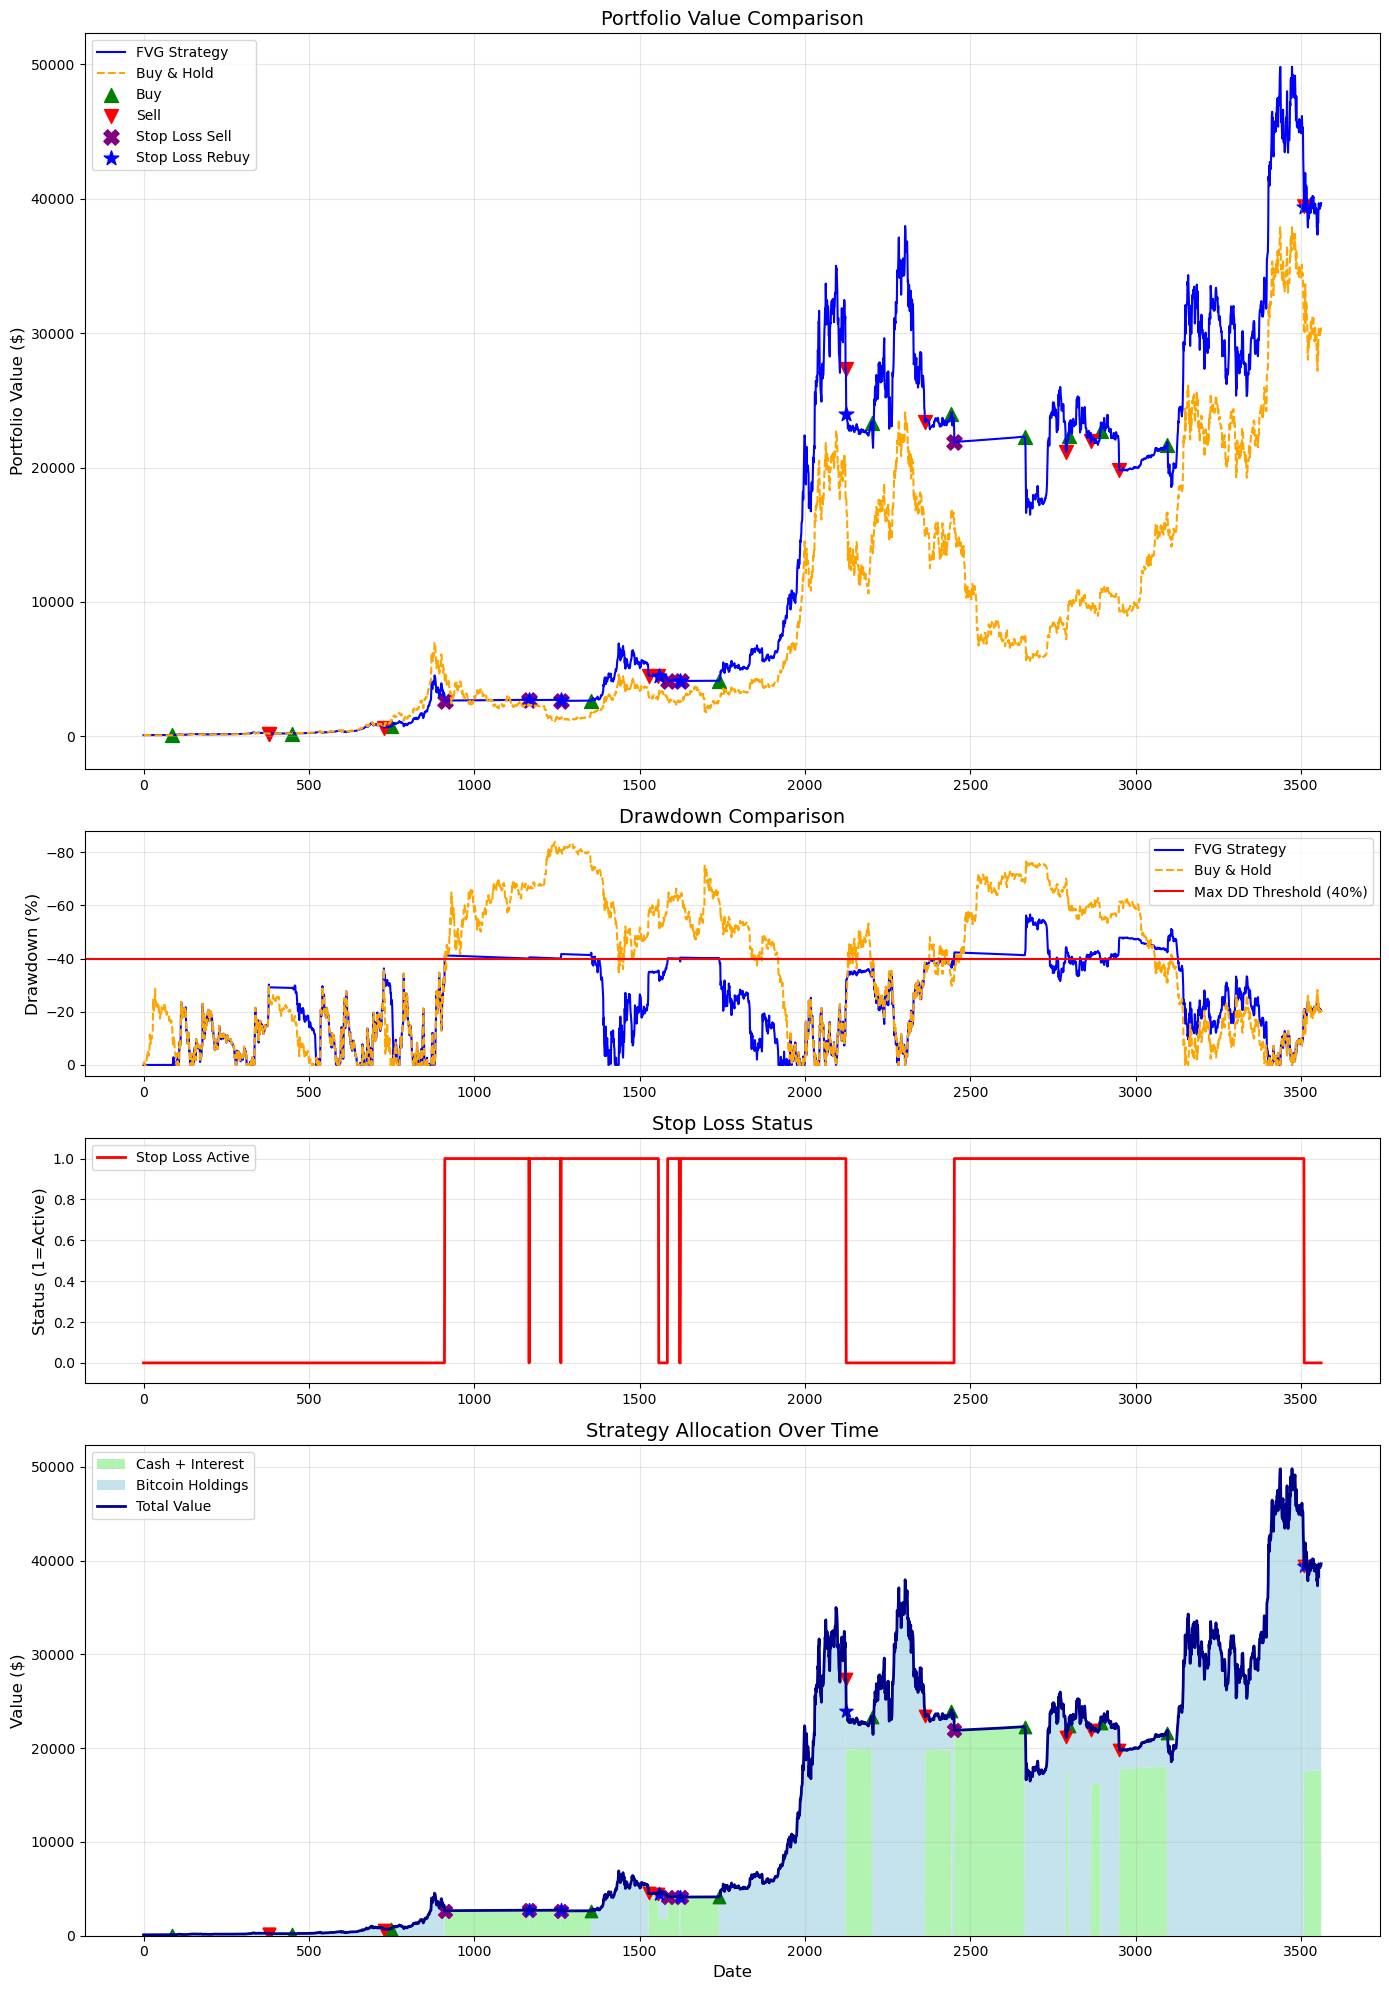

In [2]:
from evaluate import TraderWithStoploss

evaluator = TraderWithStoploss(initial_cash=100, commission_rate=0.001, risk_free_rate=rf, max_drawdown_threshold=40)
evaluator.backtest_strategy(signals_df)
evaluator.calculate_buy_and_hold(signals_df)

# Print and visualize results
evaluator.print_performance_summary()
evaluator.plot_results()